# Network Analysis Using Reinforcement Learning
## Spring 2022: Shaoyu Pei, Avery Peiffer

## Advisor: Dr. Mai Abdelhakim

## Notebook 2: Applying Reinforcement Learning to the Problem
If you have not already read through and tested out the network setup, please take some time to do so. It will provide you with the necessary background to understand the problem.

The purpose of this notebook 

**Note:** If you get any errors due to packages not being installed, please add them to the snippet below. We might have not encountered these errors due to already having those packages installed on our computers for other courses/projects/etc.

In [1]:
!pip3 install gym

In [2]:
import gym
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from gym import spaces

## Part I: Environment Setup
In this section, we walk through the logic used to create the network environment that will be used later for the reinforcement learning algorithms. We represent a network as a graph, made up of edges and nodes. The nodes represent devices and the edges represent connections between devices. We use a partial mesh topology to define the network, which means that not all pairs of nodes are directly connected to each other (which would be a full mesh topology). 

All of the hyperparameters we use for creating the network environment:
* `network_size` is the number of nodes in the graph (including the source and destination nodes)
* `edge_prob` is the probability of an edge occurring between nodes when generating the graph
* `percent_mal` is the percentage of malicious nodes
* `attack_probs` are the bounds for the uniform distribution from which we will draw the attack probability of each malicious node

In [3]:
network_size = 20      
edge_prob = 0.1 
percent_mal = 0.3
attack_probs = [0.2, 0.8] 

Some helper methods to use when creating the graph:
* `render` visualizes the graph
* `random_edge` is used to make sure the graph is connected, since the graph is generated randomly and sometimes will not be one single component 

In [4]:
def render(graph):
    nx.draw(graph, with_labels=True)
    plt.show()

In [5]:
def random_edge(graph):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    chosen_edge = random.choice(edges)
    chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
    
    graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
    
    return graph

Here we create a random graph and add random edges until it is fully connected (meaning there is a path that takes you from a node to every other node). Then, we visualize the graph. For simplicity, `src` is always Node 0 and `dst` is always the highest-numbered node.

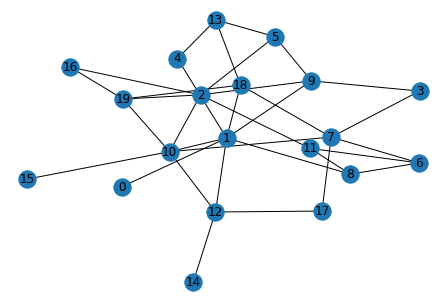

In [6]:
src = 0
dst = network_size - 1

G = nx.gnp_random_graph(network_size, edge_prob)

while not nx.is_connected(G):
    G = random_edge(G)

render(G)

We use the `agent` class to store information about each node. The `agent` class is created somewhat lazily, without any actual class definition. We will later define the attributes for each agent.

In [7]:
class agent:
    pass

We randomly assign some number (according to `percent_mal`) of the nodes to be malicious. We will assume that the source and destination nodes can't be malicious.

In [8]:
mal_nodes = []

num_mal = int(network_size * percent_mal)

while (num_mal > 0):
    rand = np.random.randint(0, network_size)
    
    if rand != 0 and rand != network_size-1 and rand not in mal_nodes:
        mal_nodes.append(rand)
        num_mal -= 1

For each node in the graph, we create an `agent` class for it. Each agent has the following attributes:
* `node`: The node in the graph that the agent corresponds to 
* `mal`: Whether or not the node is malicious
* `attack_prob`: Random number drawn from a uniform distribution with bounds highlighted in the hyperparameters section; this indicates how likely a malicious node is to "attack"

In [9]:
nodes = list(range(0, network_size))
agents = []

for node in nodes:
    a = agent()
    a.node = node
    
    if node in mal_nodes:
        a.mal = True
        a.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
    else:
        a.mal = False
        a.attack_prob = 0
        
    agents.append(a)

This section provides an example of determining if a path from the source to the destination is corrupted. For each malicious node along the path, a random number is generated and compared to that node's attack probability to see if it will attack the path. The paths are generated using `nx.all_simple_paths()`. This function generates all paths from the source to the destination without doubling back on nodes.
* Note: `nx.all_simple_paths` might take some time to run if the number of nodes is high. 

In [10]:
def is_corrupted(path, verbose=False):
    for node in path: 
        attack_prob = agents[node].attack_prob
        attacked = random.uniform(0,1) < attack_prob
        
        if attacked:
            if verbose:
                print('Path = ', path)
                print('Node %d attacked this path' % node)
            return True
    return False

In [11]:
paths = list(nx.all_simple_paths(G, src, dst))
paths_corruption = []

for path in paths:
    paths_corruption.append(is_corrupted(path))

## Part 2: Reinforcement Learning (RL)

### RL Overview

In this section, we use everything from above to implement a class for our network environment. This allows us to actually train reinforcement learning algorithms. We modified [Laura D'Arcy's GraphRLnx repository](https://github.com/lauradarcy/graphRLnx) to create this class.

Please see the `tutorials/` folder for an overview of reinforcement learning. Essentially, we wish for our algorithm to learn the optimal path(s) from the source to the destination, taking into consideration the number of hops and the corrupted nodes along the way. The nodes of the graph represent both the state and action spaces of our graph. At each node, we move to one of its neighbors. We assign a reward based on how many hops it takes to reach the destination from the source node. Additionally, our reward depends on whether or not the chosen path is corrupted. Over time, our algorithm will go from picking paths at random to picking the paths that are short and unlikely to be corrupted.

The `graphRL` class, which uses the `gym` environment structure.

In [12]:
class graphRL(gym.Env):  
    def random_edge(self):
        edges = list(self.graph.edges)
        nonedges = list(nx.non_edges(self.graph))
        if len(edges) > 0:
            chosen_edge = random.choice(edges)
            chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
        else:
            chosen_nonedge = random.choice(nonedges)
        self.graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
        
    def is_corrupted(self, path, verbose=False): 
        for node in path:
            attack_prob = self.agents[node].attack_prob
            attacked = random.uniform(0,1) < attack_prob
            if attacked:
                if verbose:
                    print('Node = ', node)
                return True
        return False

    def __init__(self, network_size=10, edge_prob=1, percent_mal=0, attack_probs=[0, 0]):
        self.network_size = network_size
        self.src = 0
        self.dst = network_size - 1
        
        self.graph = nx.gnp_random_graph(network_size, edge_prob)
        while not nx.is_connected(self.graph):
            self.random_edge()
            
        self.mal_nodes = []
        num_mal = network_size * percent_mal
        
        while num_mal > 0:
            rand = np.random.randint(0, network_size)           
            if rand != src and rand != dst and rand not in self.mal_nodes:
                self.mal_nodes.append(rand)
                num_mal -= 1
            
        class agent:
            pass
        
        nodes = list(range(0, network_size))
        self.agents = []
        
        for node in nodes:
            a = agent()
            a.node = node
            
            if node in self.mal_nodes:
                a.mal = True
                a.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
            else:
                a.mal = False
                a.attack_prob = 0
            
            self.agents.append(a)
            
        self.num_actions = network_size
        self.num_states  = network_size
            
        self.action_space = spaces.Discrete(self.num_actions)                   
        self.observation_space = spaces.Discrete(self.num_states)
        
        self.reset()

    def render(self):
        nx.draw(self.graph, with_labels=True)
        plt.show()

    def step(self, action):
        done = 0
        reward = 0
        assert self.action_space.contains(action)
        
        reward -= 1 # 
        
#         if self.is_corrupted(action):
#             reward -= corrupted_node_penalty
        
        self.time_step += 1
        return action, reward, done, {"time_step": self.time_step}

    def reset(self):
        self.time_step = 0
        self.observation = nx.to_numpy_matrix(self.graph).astype(int) # I'm not sure if this is needed
        return self.observation

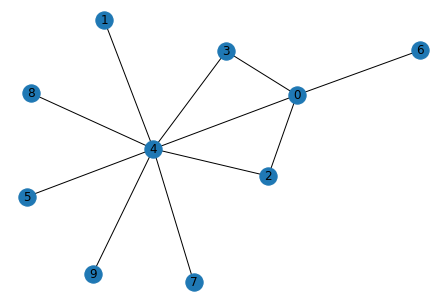

In [13]:
env = graphRL(network_size=10, edge_prob=0.1, percent_mal=0.4, attack_probs=[0.3, 0.8])

env.render()

Here, we print out all of the nodes and whether they are malicious. This will help us confirm that our algorithm is learning to avoid the malicious nodes. By visual inspection, we can also confirm that our algorithm is learning the shortest paths from source to destination.

In [14]:
for a in env.agents:
    if a.mal:
        print(f'Node {a.node} IS malicious. Attack probability is {a.attack_prob:.2f}.')
    else:
        print(f'Node {a.node} is NOT malicious.')

Node 0 is NOT malicious.
Node 1 is NOT malicious.
Node 2 is NOT malicious.
Node 3 is NOT malicious.
Node 4 is NOT malicious.
Node 5 IS malicious. Attack probability is 0.69.
Node 6 is NOT malicious.
Node 7 IS malicious. Attack probability is 0.44.
Node 8 IS malicious. Attack probability is 0.38.
Node 9 IS malicious. Attack probability is 0.74.


Some hyperparameters we introduce when we move to a RL environment:
* `corrupted_node_penalty` refers to the penalty our algorithm incurs when it encounters a corrupted node.
* `dead_end_penalty` refers to the penalty our algorithm incurs when it encounters a dead-end node. We don't need to consider this node for future pathfinding, so we put an enormous penalty on it.

The other hyperparameters are used for the Q-learning algorithm (definitions used from the [RL tutorial source](https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/)):
* `alpha` is the learning rate (0 < $\alpha$ <= 1). This captures the extent to which the Q-values are updated from one training iteration.
* `gamma` is the discount factor (0 < $\gamma$ <= 1). $\gamma$ determines how much importance we want to give to future rewards. A lower $\gamma$ makes our algorithm consider immediate rewards more, while a higher $\gamma$ captures a long-term effective reward.
* `epsilon` is the degree (0 < $\epsilon$ <= 1) to which we want to explore the action space (i.e. pick a random value) or exploit our learned Q-values. A lower $\epsilon$ will result in more penalties during training because we are more often picking new, unexplored paths. A higher $\epsilon$ will result in fewer penalties during training but may lead to overfitting.

In [15]:
q_table = np.zeros([env.num_states, env.num_actions])

corrupted_path_penalty = 10
clean_path_reward = corrupted_path_penalty # Is this something to have? 
dead_end_penalty = 1000 # Continue working on this 
# Node: don't want this to be np.inf because it will fail in some edge cases (since invalid neighbors are np.inf)

alpha = 0.1
gamma = 0.6
epsilon = 0.1

In [16]:
VISITED = -1

# For plotting metrics
all_epochs = []
all_penalties = []

# Number of training iterations
for i in range(1, 100001):
    total_penalty = 0
    path = []
    state = env.src

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    visit_arr = np.zeros(network_size) # 
    
    while not done:
        path.append(state)
        dead_end = True
        visit_arr[state] = VISITED # Shows that we have visited a node
        
        valid_neighbors = list(env.graph.neighbors(state)) # These are the valid possible actions
        
        # Check to see if the node is a dead end
        for neighbor in valid_neighbors:
            if visit_arr[neighbor] != VISITED:
                dead_end = False
        
        # This node is a dead end, so we put a giant penalty on it so we don't go to it again in future iterations
        if dead_end:
            q_table[:, state] = -dead_end_penalty 
            done = True

        # The node is not a dead end, so we continue trying to find paths to the destination
        else:  
            # Explore the action space
            # We have to make sure the selected action is valid, but otherwise we are picking a random action
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
                while action not in valid_neighbors or visit_arr[action] == VISITED: # 
                    action = env.action_space.sample()
            
            # Exploit learned values
            # We have to make sure the selected action is valid, but otherwise we are picking the action with the highest Q-value
            else:
                slc = q_table[state]
                action = np.argmax(slc)               

                while action not in valid_neighbors or visit_arr[action] == VISITED:
                    slc[action] = -np.Inf
                    action = np.argmax(slc)

            next_state, reward, done, info = env.step(action)  # keep track of total reward

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state

            if state == env.dst:
                path.append(state)
                done = True
                
            total_penalty += 1 # += reward
            epochs += 1
            
    if dead_end == True:
        print(f'Path taken = {path}. Encountered a dead end.')
    else:
        print(f'Path taken = {path}.')
        
        if env.is_corrupted(path): # hash
            for node in path[1:len(path)-2]: #
                q_table[:, node] -= corrupted_path_penalty / len(path)
            total_penalty += corrupted_path_penalty
            print(f'This path was corrupted.')
            
        ## Is this necessary? 
        else:
            for node in path[1:len(path)-2]:
                q_table[:, node] += clean_path_reward / len(path)
            
    all_epochs.append(i)
    all_penalties.append(total_penalty)
        
    if i % 100 == 0:
        #clear_output(wait=True)
        print(f"Episode: {i}")

Path taken = [0, 2, 4, 1]. Encountered a dead end.
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was cor

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path wa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9]

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 1100
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path w

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was 

Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9

This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end

Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encou

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 4200
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path t

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead e

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Pa

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrup

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This p

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
P

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 7100
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Episode: 7500
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Thi

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 7800
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = 

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Th

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 8]. Encountered a dead end.
Path taken = [0, 4,

Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 10200
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path tak

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 10800
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = 

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Episode: 12200
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 

Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountere

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrup

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 16100
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path wa

Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 16400
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This pat

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
T

Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].

Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 17400
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken 

Path taken = [0, 4, 1]. Encountered a dead end.
Episode: 17600
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken =

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Enc

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path 

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Episode: 19000
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = 

This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 19700
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. En

Path taken = [0, 4, 9].
This path was corrupted.
Episode: 20000
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4,

Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Pat

Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 22200
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path ta

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Episode: 22500
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
P

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 5]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was c

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 24000
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a d

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 24700
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was cor

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
P

Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 7]

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.


This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
P

Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Th

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was cor

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corr

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken 

Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 29200
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This p

Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 30400
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path 

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path t

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corr

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0,

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Episode: 32100
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4,

Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
T

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corr

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrup

Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encou

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken

Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path tak

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
T

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 37000
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken 

This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Episode: 37200
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Episode: 37400
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path ta

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 38100
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 38500
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Episode: 39000
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path t

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 39200
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 39800
Path taken = [0, 4, 9].


Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.


Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupte

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Episode: 40600
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken 

Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9]

Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Th

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 43900
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This p

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. En

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Enco

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 45700
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 5]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Th

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 47500
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path ta

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path t

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
P

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 50000
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path wa

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupt

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
P

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path

Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 7]. Encountered a dead end.
Path taken = [0, 3, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
T

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path t

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Episode: 52900
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Episode: 53200
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path 

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corru

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9

Path taken = [0, 3, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 54300
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path tak

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
T

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 56500
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path take

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
P

This path was corrupted.
Path taken = [0, 2, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 3, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 57700
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path

Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was c

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4,

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 8]. Encounter

Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Episode: 60000
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path take

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 60700
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path wa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path 

This path was corrupted.
Path taken = [0, 3, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corru

Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupte

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].

This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.

This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was co

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path t

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path

Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path wa

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path t

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corru

Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9]

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 64800
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 2, 4, 

Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 65700
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path take

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 66000
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = 

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 66300
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path w

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Episode: 67200
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path w

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 67600
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This 

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead en

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path 

Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
T

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Pat

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path 

Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 72600
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken =

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 3]. Encountered a dead end.
Episode: 72900
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4,

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Episode: 73100
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path take

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Episode: 73900
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrup

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. E

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrup

Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Pat

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupte

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This p

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.

Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
P

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.


Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 77800
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This pat

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This

Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This p

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path take

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupt

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupt

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
T

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Th

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 81700
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path tak

Path taken = [0, 4, 9].
Episode: 82000
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path tak

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 82500
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path w

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 83100
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 7]. Encountered a dead end.
Path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 84000
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path wa

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Pa

Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupt

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9]

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].

Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken

Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
P

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corru

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].

Path taken = [0, 3, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Episode: 88700
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This 

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corr

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken =

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0

Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].


Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 90600
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This pa

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This 

Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path t

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Pa

This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Episode: 92300
Path taken = [0, 4, 9].
This path was corrupted.
Path taken

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Episode: 93500
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 93800
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path tak

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Pat

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Pa

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 2, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Episode: 95600
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path 

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9]

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path t

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead en

This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4,

Path taken = [0, 4, 9].
This path was corrupted.
Episode: 97600
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken

Path taken = [0, 4, 5]. Encountered a dead end.
Episode: 97900
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was 

Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 3, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 98700
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupte

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 8]. Encountered a dead end.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Enc

Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 7]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
P

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 3]. Encountered a dead end.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 2, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 1]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Episode: 99400
Path taken = [0, 4, 5]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was cor

Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
Path ta

Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 6]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 2]. Encountered a dead end.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This path was corrupted.
Path taken = [0, 4, 9].
This

In [17]:
import pandas as pd

print(pd.DataFrame(q_table))

     0       1         2       3    4       5       6       7       8    9
0 -inf -1000.0  -902.696 -1000.0 -1.6 -1000.0 -1000.0 -1000.0 -1000.0 -inf
1  0.0 -1000.0 -1002.500 -1000.0  0.0 -1000.0 -1000.0 -1000.0 -1000.0  0.0
2 -inf -1000.0 -1002.500 -1000.0 -1.6 -1000.0 -1000.0 -1000.0 -1000.0 -inf
3 -inf -1000.0 -1002.500 -1000.0 -1.6 -1000.0 -1000.0 -1000.0 -1000.0 -inf
4 -inf -1000.0 -1002.500 -1000.0 -inf -1000.0 -1000.0 -1000.0 -1000.0 -1.0
5  0.0 -1000.0 -1002.500 -1000.0  0.0 -1000.0 -1000.0 -1000.0 -1000.0  0.0
6  0.0 -1000.0 -1002.500 -1000.0  0.0 -1000.0 -1000.0 -1000.0 -1000.0  0.0
7  0.0 -1000.0 -1002.500 -1000.0  0.0 -1000.0 -1000.0 -1000.0 -1000.0  0.0
8  0.0 -1000.0 -1002.500 -1000.0  0.0 -1000.0 -1000.0 -1000.0 -1000.0  0.0
9  0.0 -1000.0 -1002.500 -1000.0  0.0 -1000.0 -1000.0 -1000.0 -1000.0  0.0


In [18]:
"""Evaluate agent's performance after Q-learning"""

total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

AssertionError: 